# Fixed Grid Quantization Experiment: Convergence, Computation Time, and Absolute Error Analysis

**Overview:**  
In this notebook we analyze the performance of the adapted Wasserstein distance computation using a fixed quantization grid of **0.005**.  
 
We run experiments for various sample sizes:

- **Sample Sizes:** 3000, 7000, 10000, 13000, 17000, and 20000
- **Number of Runs per Sample Size:** 10 (each with a different random seed)

**Experimental Steps:**  
1. For fixed matrices `L` and `M` (or any matrices you choose), we generate sample paths using the function `Lmatrix2paths`.  
2. For each nontrivial time step (t = 1,...,T), we apply basic grid quantization by rounding to the nearest multiple of 0.005.
3. The quantized paths are then converted into index sequences (using a unique mapping), sorted, and their conditional distributions are built.
4. The numerical adapted Wasserstein squared distance is computed using `nested2_parallel`.
 
**Outputs:**  
- **Distance Convergence:** Mean computed AW² (± standard deviation) vs. sample size with the benchmark value shown.
- **Computation Time:** Mean computation time (± standard deviation) vs. sample size.
- **Absolute Error:** Mean absolute error (|computed mean – benchmark|, ± standard deviation) vs. sample size.
 
This code is organized to be general so you can use it with other matrices or grid settings with minimal changes.

In [2]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up the source path (adjust as needed for your project structure)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from adapted_empirical_measure.AEM_grid import *

## Experiment Setup

- **Fixed Grid Size:** 0.005  
- **Sample Sizes:** [3000, 7000, 10000, 13000, 17000, 20000]  
- **Runs per Sample Size:** 10  
- **Time Horizon (T):** 3  
- **Matrices:** (You can replace these with other matrices if needed)

We use:

$$
L = \begin{pmatrix} 1 & 0 & 0 \\ 2 & 4 & 0 \\ 3 & 2 & 1 \end{pmatrix},\quad
M = \begin{pmatrix} 1 & 0 & 0 \\ 2 & 3 & 0 \\ 3 & 1 & 2 \end{pmatrix}.
$$

In [3]:
# Experiment parameters
sample_sizes = [1000, 2000, 4000, 6000, 8000, 10000, 12000, 15000]
fixed_grid = 0.01
n_runs = 10
T = 3  # Number of time steps (excluding the trivial initial state)

# Define matrices (change these as needed for other experiments)
L = np.array([[1, 0, 0],
              [2, 4, 0],
              [3, 2, 1]])
M = np.array([[1, 0, 0],
              [2, 3, 0],
              [3, 1, 2]])

## Main Experiment Loop
 
For each sample size we perform 10 runs. In every run:
 
1. Generate sample paths for X and Y using `Lmatrix2paths` (each run uses a new random seed).
2. Compute the theoretical benchmark distance using `adapted_wasserstein_squared` (which depends only on L and M).
3. For each nontrivial time step (t = 1,...,T), apply the basic grid quantization (with grid size = 0.005).
4. Map the quantized paths to indices, sort them, build conditional distributions, and compute the numerical adapted Wasserstein squared distance.
5. Record both the computed distance and the elapsed computation time.

In [4]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    # Arrays to hold the results of each run (1D arrays since grid is fixed)
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    for run in range(n_runs):
        # New random seed for each run
        random_seed = np.random.randint(10000)
        
        # Generate sample paths (X for process 1 and Y for process 2)
        X, A = Lmatrix2paths(L, n_sample, seed=random_seed, verbose=False)
        Y, B = Lmatrix2paths(M, n_sample, seed=random_seed, verbose=False)
        
        # Compute the theoretical benchmark (A and B depend solely on L and M)
        benchmark = adapted_wasserstein_squared(A, B)
        
        adaptedX = path2adaptedpath(X, delta_n = fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n = fixed_grid)
        
        # Quantization map
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}  # Value to Quantization

        # Quantized paths
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])

        # Sort paths and transpose to (n_sample, T+1)
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)

        # Get conditional distribution mu_{x_{1:t}} = mu_x[t][(x_1,...,x_t)] = {x_{t+1} : mu_{x_{1:t}}(x_{t+1}), ...}
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)

        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)
        
        # Compute the numerical adapted Wasserstein squared distance and time the computation
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")

    # Store results for this sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 1000


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.05it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.82it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 389.41it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 278.30it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 70.06it/s]


Sample size 1000, Run 1: AW_2^2 = 2.9915, Time = 1.8691 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.98it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.29it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 294.06it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 119.40it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 96.05it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 79.06it/s]


Sample size 1000, Run 2: AW_2^2 = 2.9966, Time = 1.6118 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 382.06it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 412.93it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 379.26it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 414.44it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 416.93it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 392.82it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 415.29it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 95.60it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 99.41it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 80.84it/s]


Sample size 1000, Run 3: AW_2^2 = 2.7668, Time = 1.3834 s


  0%|                                                    | 0/24 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.19it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 416.61it/s]

  0%|                                                    | 0/23 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 410.87it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 390.89it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 226.49it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 293.03it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 85.90it/s]


Sample size 1000, Run 4: AW_2^2 = 2.6783, Time = 1.3925 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 388.78it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.30it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 415.85it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 416.63it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 107.00it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 109.56it/s]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 98.99it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 110.03it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 126.01it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 699.14it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 296.96it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 78.00it/s]


Sample size 1000, Run 5: AW_2^2 = 2.9587, Time = 1.3544 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 416.63it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.56it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 414.52it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 416.23it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 414.94it/s]

  0%|                                                     | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 101.35it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 109.85it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 143.08it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 215.69it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 282.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 85.52it/s]


Sample size 1000, Run 6: AW_2^2 = 2.8539, Time = 1.6497 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 417.56it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 369.57it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 119.96it/s]

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 99.45it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 89.89it/s]


Sample size 1000, Run 7: AW_2^2 = 3.2973, Time = 1.8115 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 411.78it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 413.62it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.09it/s]

  0%|                                                    | 0/24 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.51it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.46it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 416.04it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 399.12it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 119.22it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 109.25it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 153.89it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 403.42it/s]

100%|███████████

Sample size 1000, Run 8: AW_2^2 = 2.8203, Time = 1.4284 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 413.76it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 387.21it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 414.28it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 82.39it/s]


Sample size 1000, Run 9: AW_2^2 = 2.9591, Time = 1.6957 s


  0%|                                                    | 0/24 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 414.53it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 413.15it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 415.28it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 387.91it/s]

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 168.71it/s]

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 110.16it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 88.47it/s]


Sample size 1000, Run 10: AW_2^2 = 3.1014, Time = 1.6774 s

Running experiments for sample size: 2000


 83%|███████████████████████████████████       | 40/48 [00:00<00:00, 176.86it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 183.15it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 204.21it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 190.85it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 205.54it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.75it/s]


Sample size 2000, Run 1: AW_2^2 = 2.9013, Time = 3.2976 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 196.30it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 207.48it/s]

100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 190.70it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 51.92it/s]


Sample size 2000, Run 2: AW_2^2 = 2.8500, Time = 3.6159 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 202.75it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 207.33it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 107.15it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.97it/s]


Sample size 2000, Run 3: AW_2^2 = 2.9146, Time = 3.7763 s


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 199.81it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 204.16it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.62it/s]


Sample size 2000, Run 4: AW_2^2 = 3.1245, Time = 3.7772 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 205.78it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 83.15it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.10it/s]


Sample size 2000, Run 5: AW_2^2 = 3.0014, Time = 2.9420 s


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 204.77it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 206.63it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 44.80it/s]


Sample size 2000, Run 6: AW_2^2 = 2.9634, Time = 3.0257 s


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 206.68it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.70it/s]


Sample size 2000, Run 7: AW_2^2 = 3.0382, Time = 2.9076 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 206.12it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 206.71it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 45.47it/s]


Sample size 2000, Run 8: AW_2^2 = 2.9641, Time = 2.7900 s


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 200.29it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 207.16it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 49.42it/s]


Sample size 2000, Run 9: AW_2^2 = 3.0905, Time = 3.8587 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 200.59it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 74.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 50.37it/s]


Sample size 2000, Run 10: AW_2^2 = 2.8788, Time = 3.7397 s

Running experiments for sample size: 4000


100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 97.97it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.78it/s]


Sample size 4000, Run 1: AW_2^2 = 2.9874, Time = 9.3199 s


100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 101.18it/s]


100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 101.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.27it/s]


Sample size 4000, Run 2: AW_2^2 = 3.0670, Time = 11.5348 s


100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 102.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.15it/s]


Sample size 4000, Run 3: AW_2^2 = 3.0306, Time = 11.1852 s


100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 102.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.09it/s]


Sample size 4000, Run 4: AW_2^2 = 3.0310, Time = 10.8898 s


100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 97.58it/s]

100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 97.68it/s]

100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 96.14it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.70it/s]


Sample size 4000, Run 5: AW_2^2 = 2.8901, Time = 10.9468 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.81it/s]


Sample size 4000, Run 6: AW_2^2 = 3.0368, Time = 10.8658 s


 92%|███████████████████████████████████████▍   | 87/95 [00:00<00:00, 98.92it/s]


100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 98.64it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.02it/s]


Sample size 4000, Run 7: AW_2^2 = 3.0692, Time = 10.7507 s


100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 101.85it/s]

100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 102.77it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.48it/s]


Sample size 4000, Run 8: AW_2^2 = 2.9952, Time = 10.7497 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.90it/s]


Sample size 4000, Run 9: AW_2^2 = 2.9999, Time = 11.3685 s


100%|███████████████████████████████████████████| 95/95 [00:00<00:00, 99.82it/s]

100%|██████████████████████████████████████████| 95/95 [00:00<00:00, 101.46it/s]

100%|███████████████████████████████████████████| 94/94 [00:00<00:00, 96.78it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.05it/s]


Sample size 4000, Run 10: AW_2^2 = 3.1006, Time = 10.7955 s

Running experiments for sample size: 6000


 74%|██████████████████████████████▎          | 105/142 [00:01<00:00, 63.55it/s]

 94%|██████████████████████████████████████▍  | 133/142 [00:02<00:00, 66.52it/s]


100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 67.94it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.86it/s]


Sample size 6000, Run 1: AW_2^2 = 3.0222, Time = 18.9746 s


100%|█████████████████████████████████████████| 143/143 [00:02<00:00, 67.68it/s]

 99%|████████████████████████████████████████▍| 140/142 [00:02<00:00, 67.67it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.28it/s]


Sample size 6000, Run 2: AW_2^2 = 2.9583, Time = 19.1187 s


100%|█████████████████████████████████████████| 143/143 [00:02<00:00, 65.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.19it/s]


Sample size 6000, Run 3: AW_2^2 = 3.0330, Time = 21.3378 s


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 65.96it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.47it/s]


Sample size 6000, Run 4: AW_2^2 = 3.0088, Time = 19.3934 s


100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 65.86it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.58it/s]


Sample size 6000, Run 5: AW_2^2 = 2.9725, Time = 19.3243 s


100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 65.30it/s]

 79%|████████████████████████████████▎        | 112/142 [00:01<00:00, 66.36it/s]

100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 66.37it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.71it/s]


Sample size 6000, Run 6: AW_2^2 = 2.9890, Time = 18.9103 s


100%|█████████████████████████████████████████| 143/143 [00:02<00:00, 64.79it/s]

100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 62.93it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.99it/s]


Sample size 6000, Run 7: AW_2^2 = 3.0095, Time = 19.4688 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.49it/s]


Sample size 6000, Run 8: AW_2^2 = 3.0146, Time = 21.8133 s


100%|█████████████████████████████████████████| 142/142 [00:02<00:00, 64.84it/s]

100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 64.02it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.11it/s]


Sample size 6000, Run 9: AW_2^2 = 3.0827, Time = 19.5272 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.92it/s]


Sample size 6000, Run 10: AW_2^2 = 3.0680, Time = 20.1057 s

Running experiments for sample size: 8000


100%|█████████████████████████████████████████| 189/189 [00:03<00:00, 48.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.60it/s]


Sample size 8000, Run 1: AW_2^2 = 3.0356, Time = 37.1992 s


 80%|████████████████████████████████▊        | 151/189 [00:03<00:00, 49.87it/s]

100%|█████████████████████████████████████████| 189/189 [00:03<00:00, 48.76it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.33it/s]


Sample size 8000, Run 2: AW_2^2 = 3.0003, Time = 36.8078 s


100%|█████████████████████████████████████████| 189/189 [00:03<00:00, 48.21it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.02it/s]


Sample size 8000, Run 3: AW_2^2 = 2.9839, Time = 35.5091 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.17it/s]


Sample size 8000, Run 4: AW_2^2 = 3.0246, Time = 37.5618 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.67it/s]


Sample size 8000, Run 5: AW_2^2 = 3.0117, Time = 36.8992 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.29it/s]


Sample size 8000, Run 6: AW_2^2 = 3.0937, Time = 36.6461 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.29it/s]


Sample size 8000, Run 7: AW_2^2 = 2.9730, Time = 36.8996 s


100%|█████████████████████████████████████████| 189/189 [00:03<00:00, 49.18it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Sample size 8000, Run 8: AW_2^2 = 3.0586, Time = 36.9607 s


 97%|███████████████████████████████████████▋ | 183/189 [00:03<00:00, 48.84it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.53it/s]


Sample size 8000, Run 9: AW_2^2 = 2.9929, Time = 38.5310 s


100%|█████████████████████████████████████████| 189/189 [00:03<00:00, 49.06it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.85it/s]


Sample size 8000, Run 10: AW_2^2 = 3.0248, Time = 36.2709 s

Running experiments for sample size: 10000


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.00it/s]


Sample size 10000, Run 1: AW_2^2 = 2.9700, Time = 54.1473 s


100%|█████████████████████████████████████████| 235/235 [00:06<00:00, 38.63it/s]

100%|█████████████████████████████████████████| 235/235 [00:06<00:00, 38.61it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.96it/s]


Sample size 10000, Run 2: AW_2^2 = 3.0734, Time = 53.3973 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.98it/s]


Sample size 10000, Run 3: AW_2^2 = 3.0686, Time = 56.0447 s


100%|█████████████████████████████████████████| 236/236 [00:06<00:00, 38.45it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.84it/s]


Sample size 10000, Run 4: AW_2^2 = 3.0880, Time = 54.8302 s


100%|█████████████████████████████████████████| 236/236 [00:06<00:00, 38.88it/s]

100%|█████████████████████████████████████████| 236/236 [00:05<00:00, 39.45it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.89it/s]


Sample size 10000, Run 5: AW_2^2 = 3.0340, Time = 55.3244 s


 74%|██████████████████████████████▏          | 174/236 [00:04<00:01, 39.22it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.78it/s]


Sample size 10000, Run 6: AW_2^2 = 3.0757, Time = 55.4906 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.89it/s]


Sample size 10000, Run 7: AW_2^2 = 3.0771, Time = 54.5029 s


100%|█████████████████████████████████████████| 236/236 [00:06<00:00, 38.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


Sample size 10000, Run 8: AW_2^2 = 3.0220, Time = 55.3346 s


 97%|███████████████████████████████████████▊ | 229/236 [00:05<00:00, 37.47it/s]

100%|█████████████████████████████████████████| 235/235 [00:06<00:00, 39.09it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.19it/s]


Sample size 10000, Run 9: AW_2^2 = 3.0144, Time = 55.2203 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.40it/s]


Sample size 10000, Run 10: AW_2^2 = 3.0458, Time = 55.2703 s

Running experiments for sample size: 12000


 86%|███████████████████████████████████▏     | 242/282 [00:07<00:01, 32.68it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.29it/s]


Sample size 12000, Run 1: AW_2^2 = 3.0471, Time = 74.1593 s


 84%|██████████████████████████████████▍      | 237/282 [00:07<00:01, 30.90it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.17it/s]


Sample size 12000, Run 2: AW_2^2 = 3.0258, Time = 77.9480 s


100%|█████████████████████████████████████████| 282/282 [00:08<00:00, 31.89it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.63it/s]


Sample size 12000, Run 3: AW_2^2 = 3.0325, Time = 74.0829 s


100%|█████████████████████████████████████████| 283/283 [00:08<00:00, 32.50it/s]

 81%|█████████████████████████████████▏       | 228/282 [00:07<00:01, 30.86it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.19it/s]


Sample size 12000, Run 4: AW_2^2 = 3.0720, Time = 77.8242 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.49it/s]


Sample size 12000, Run 5: AW_2^2 = 3.0070, Time = 79.5680 s


100%|█████████████████████████████████████████| 283/283 [00:08<00:00, 32.31it/s]

100%|█████████████████████████████████████████| 282/282 [00:08<00:00, 31.52it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.88it/s]


Sample size 12000, Run 6: AW_2^2 = 3.0847, Time = 78.5358 s


 98%|████████████████████████████████████████▎| 278/283 [00:08<00:00, 33.63it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.64it/s]


Sample size 12000, Run 7: AW_2^2 = 3.0911, Time = 78.5690 s


100%|█████████████████████████████████████████| 281/281 [00:08<00:00, 32.57it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.10it/s]


Sample size 12000, Run 8: AW_2^2 = 3.0433, Time = 78.8206 s


100%|█████████████████████████████████████████| 283/283 [00:08<00:00, 32.11it/s]

 77%|███████████████████████████████▍         | 216/282 [00:07<00:02, 32.03it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.84it/s]


Sample size 12000, Run 9: AW_2^2 = 3.0295, Time = 82.4887 s


100%|█████████████████████████████████████████| 282/282 [00:08<00:00, 32.44it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.45it/s]


Sample size 12000, Run 10: AW_2^2 = 3.0464, Time = 80.1759 s

Running experiments for sample size: 15000


 99%|████████████████████████████████████████▌| 348/352 [00:14<00:00, 25.08it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.40it/s]


Sample size 15000, Run 1: AW_2^2 = 3.0157, Time = 125.0577 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


Sample size 15000, Run 2: AW_2^2 = 3.0621, Time = 121.5529 s


100%|█████████████████████████████████████████| 352/352 [00:13<00:00, 25.62it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.46it/s]


Sample size 15000, Run 3: AW_2^2 = 3.0229, Time = 119.8790 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Sample size 15000, Run 4: AW_2^2 = 3.0265, Time = 134.6649 s


100%|█████████████████████████████████████████| 352/352 [00:14<00:00, 25.13it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 31.04it/s]


Sample size 15000, Run 5: AW_2^2 = 2.9889, Time = 109.2573 s


100%|█████████████████████████████████████████| 352/352 [00:14<00:00, 25.07it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 30.96it/s]


Sample size 15000, Run 6: AW_2^2 = 3.0388, Time = 117.2315 s


100%|█████████████████████████████████████████| 352/352 [00:13<00:00, 25.95it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.94it/s]


Sample size 15000, Run 7: AW_2^2 = 2.9945, Time = 109.6430 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.25it/s]


Sample size 15000, Run 8: AW_2^2 = 3.0341, Time = 118.3883 s


100%|█████████████████████████████████████████| 353/353 [00:13<00:00, 25.46it/s]

100%|█████████████████████████████████████████| 353/353 [00:13<00:00, 25.74it/s]

100%|█████████████████████████████████████████| 352/352 [00:13<00:00, 25.95it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 27.56it/s]


Sample size 15000, Run 9: AW_2^2 = 2.9890, Time = 111.3886 s


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.02it/s]


Sample size 15000, Run 10: AW_2^2 = 3.0509, Time = 110.8949 s


## Aggregating Results Across Sample Sizes
 
We now compute, for each sample size:
 
 - The mean and standard deviation of the computed adapted Wasserstein squared distance.
 - The mean and standard deviation of the computation time.
 - The mean and standard deviation of the absolute error (|computed distance – benchmark|).
 
These aggregated results will be used to generate the plots.


In [5]:
sample_list = sorted(results.keys())
mean_distances = []
std_distances = []
mean_times = []
std_times = []
mean_abs_errors = []
std_abs_errors = []
benchmarks = []  # (should be the same for all runs)

for n_sample in sample_list:
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    
    mean_distances.append(np.mean(dists))
    std_distances.append(np.std(dists))
    mean_times.append(np.mean(times))
    std_times.append(np.std(times))
    abs_errors = np.abs(dists - bench)
    mean_abs_errors.append(np.mean(abs_errors))
    std_abs_errors.append(np.std(abs_errors))
    benchmarks.append(bench)

## Plotting the Results
 
We generate three plots:
 
1. **Distance Convergence:** Mean adapted Wasserstein squared distance (± std) vs. sample size with the benchmark value indicated.
2. **Computation Time:** Mean computation time (± std) vs. sample size.
3. **Absolute Error:** Mean absolute error (± std) between the computed mean distance and the benchmark vs. sample size.

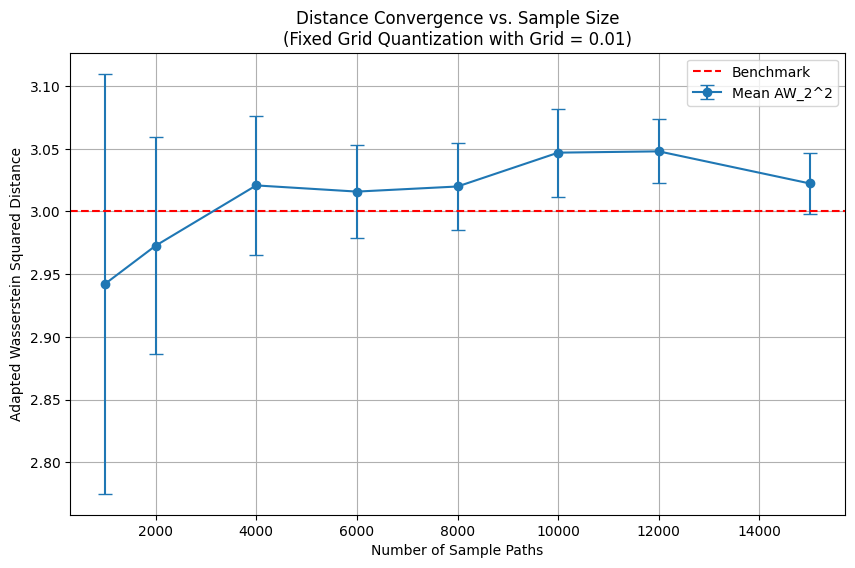

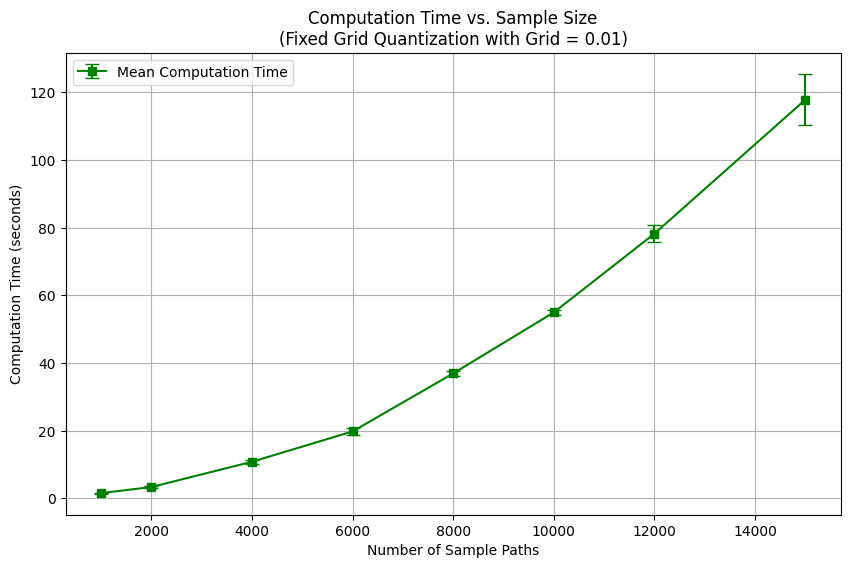

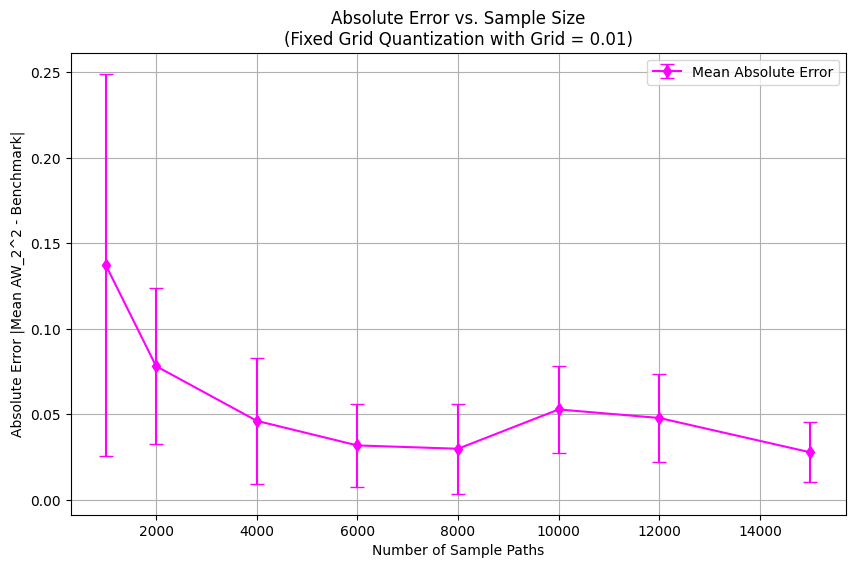

In [6]:
# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmarks[0], color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Adapted Wasserstein Squared Distance")
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Computation Time (seconds)")
plt.title("Computation Time vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths")
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|")
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid Quantization with Grid = 0.01)")
plt.legend()
plt.grid(True)
plt.show()